In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
import torchvision.models as models
import json
import os
from PIL import Image
from torchvision.ops import nms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:


class ResnetBackbone(nn.Module): # get C2, C3, C4, and C5
    def __init__(self, backbone='resnet18', pretrained=True):
        super(ResnetBackbone, self).__init__()

        # feature extractor
        self.backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        #print(self.backbone)
        self.feature_channels=[64, 128, 256, 512] # dimension for c1, c2, c3, c4 in resnet 18

        # remove last two layers of resnet18
        model_layers = list(self.backbone.children())[:-2]
        self.backbone = nn.Sequential(*model_layers)
        print(self.backbone) # view resnet18 model

        self.stem = nn.Sequential(                  #contains first residual block of resnet
            self.backbone[0],                       # conv1
            self.backbone[1],                       # batch norm
            self.backbone[2],                       # ReLU
            self.backbone[3]                        # max pooling
        )

        self.layer1 = self.backbone[4]
        self.layer2 = self.backbone[5]
        self.layer3 = self.backbone[6]
        self.layer4 = self.backbone[7]

    def forward(self, x):
        c1 = self.stem(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        return c2, c3, c4, c5
    
class FPN(nn.Module):
    def __init__(self, backbone, out_channel=256): # out_channel represents fixed number of features outputs for C5 - C2
        super(FPN, self).__init__()
        self.backbone = backbone

        # lateral convolution, merges C# -> M#
        self.lateral_layers = nn.ModuleList([
            nn.Conv2d(self.backbone.feature_channels[3], out_channel, kernel_size=1), # feature channel corresponds to layers in ResnetBackbone, eg. feature_channel[3] = C5
            nn.Conv2d(self.backbone.feature_channels[2], out_channel, kernel_size=1),
            nn.Conv2d(self.backbone.feature_channels[1], out_channel, kernel_size=1),
            nn.Conv2d(self.backbone.feature_channels[0], out_channel, kernel_size=1)   
        ])

        # smoothing 3x3 filters, smooths M4, M3, M2 -> P4, P3, P2
        self.smoothing_layers = nn.ModuleList([         #module list stores sub modules like Sequential but layer sequence can be changed in forward pass
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        ])

    def forward(self, x):
        c2, c3, c4, c5 = self.backbone(x) #bottom up path from resnet backbone

        m5 = self.lateral_layers[0](c5) #C5 -> M5, no upsampling!
        m4 = self.lateral_layers[1](c4) + F.interpolate(m5, size=c4.shape[2:], mode='nearest') #include smoothing and upsampling
        m3 = self.lateral_layers[2](c3) + F.interpolate(m4, size=c3.shape[2:], mode='nearest')
        m2 = self.lateral_layers[3](c2) + F.interpolate(m3, size=c2.shape[2:], mode='nearest')


        p5 = m5
        p4 = self.smoothing_layers[0](m4)
        p3 = self.smoothing_layers[1](m3)
        p2 = self.smoothing_layers[2](m2)

        return [p2, p3, p4, p5]
    

class BBoxRegressionHead(nn.Module):
    def __init__(self, in_channels=256):
        super(BBoxRegressionHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 4, kernel_size=3, padding=1) #four outputs

    def forward(self, x):
        return self.conv(x)
    
class TextDetector(nn.Module):
    def __init__(self, backbone, fpn, regression_head):
        super(TextDetector, self).__init__()
        self._backbone = backbone
        self.fpn = fpn
        self.bbox_regression_head = regression_head

    def forward(self, x):
        feature_maps = self.fpn(x) #[p2, p3, p4, p5]

        bbox_predictions = []
        for fmap in feature_maps:
            bbox_predictions.append(self.bbox_regression_head(fmap))

        return bbox_predictions
    



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = ResnetBackbone(backbone='resnet18')
fpn = FPN(backbone)
regression_head = BBoxRegressionHead()
model = TextDetector(backbone, fpn, regression_head)
model.load_state_dict(torch.load("TextDetectorV1.pth"))
model.to(device)
model.eval()

# Load annotations
ann_path = "./COCO-Text/COCO_Text.json"
with open(ann_path, "r") as f:
    annotations = json.load(f)


image_id = "287140"
images_path = "COCO-Text/train2014"
filename = annotations["imgs"][image_id]["file_name"]

image_path = os.path.join(images_path, filename)
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

C:\Users\Springfrost\AppData\Local\Temp\ipykernel_12832\2089636203.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("TextDetectorV1.pth")

Predicted Bounding Boxes (x_min, y_min, x_max, y_max):
tensor([[ 82.8561,  74.3309,  92.5108, 110.0545],
        [106.4917,  94.4665, 125.7524, 114.3671],
        [120.9537, 126.1093, 128.1664, 131.8244],
        [115.7252, 124.2838, 121.8698, 126.0595],
        [110.9487, 123.6176, 115.0373, 124.5730],
        [106.9994, 122.1075, 109.9579, 123.3753],
        [102.2488, 118.2828, 104.7002, 119.3941],
        [ 99.7055, 117.5155, 101.2263, 118.9855],
        [ 99.4372, 117.0376, 101.1830, 120.1865],
        [100.7750, 117.1224, 103.1263, 121.5061],
        [103.3906, 118.4675, 106.5151, 123.8090],
        [108.8636, 121.9545, 113.2408, 129.4613],
        [117.2869, 126.0358, 123.6987, 135.7646],
        [122.4417, 126.5711, 130.4044, 135.2948],
        [117.3390, 122.7111, 124.1349, 125.1152],
        [107.7304, 120.7160, 111.8985, 118.5521],
        [103.7603, 120.7525, 105.7204, 121.0264],
        [102.1025, 119.0445, 103.9276, 121.8022],
        [101.2960, 118.7601, 103.5425, 122.42

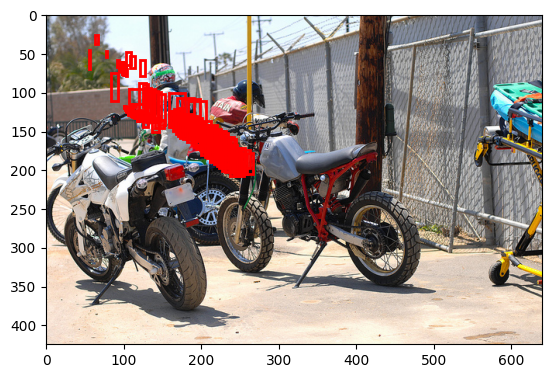

In [4]:
with torch.no_grad():
    predictions = model(image_tensor)


bbox_predictions = predictions[0].squeeze(0).permute(1, 2, 0).contiguous().view(-1, 4).cpu()

scores = torch.ones(bbox_predictions.shape[0])
nms_indices = nms(bbox_predictions, scores, iou_threshold=0.5)
final_bboxes = bbox_predictions[nms_indices]

print("Predicted Bounding Boxes (x_min, y_min, x_max, y_max):")
print(final_bboxes)



fig, ax = plt.subplots(1)
ax.imshow(image)

for bbox in final_bboxes:
    x_min, y_min, x_max, y_max = bbox
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()
